In [1]:
from __future__ import print_function
import sys
import os
import logging
import six
from radiomics import featureextractor, getFeatureClasses
import radiomics
%config Completer.use_jedi = False
import SimpleITK as sitk
import nibabel as nib
import glob
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import logging
from utils_mask_sain import *
from utils import *
from utils_recaler import *
from utils_autour_3D import *

# Faire une extraction et dilatation

In [2]:
path_data_brut = "../data/radio_brut"
current_dir = os.getcwd()
if current_dir == "/gpfs/users/selvestra/python_codes":
    path_data_brut = "/gpfs/workdir/selvestra/data/radio_brut"
path_radios = './*_NAT*/*.nii'
path_brut = os.path.join(path_data_brut, path_radios)
path_data = os.path.dirname(path_data_brut)
path_save = os.path.join(
    path_data, "multislice_excel_with_shape_2D_entre_deux.xlsx")
ls_image = sorted(glob.glob(path_brut))

# Extraire seulement une partie avec variance locale et luminosité minimale

# Critère de connexité

# Pipeline

In [3]:
# num_im = 140
# image = sitk.ReadImage(ls_image[num_im])
# mask = sitk.ReadImage(ls_image[num_im].replace('_NAT', '').replace('.nii', '_masked.nii'))
# #mask_superpose_simple(image[:,:,slice],mask[:,:,slice],other_mask =  mask_cercle[:,:,slice])
# slice= get_good_slice(ls_image[num_im])
# mask_cercle = extrac_circle(image, mask)
# variance = local_variance(image, sigma = 1.5)
# zone_high = extrac_circle(image, mask)
# new_im , mask_lum = kill_to_high(variance, zone_high,image, quantile = 0.3)
# plt.figure(figsize=(15,5))
# plt.subplot(1,4,1)
# plt.imshow(sitk.GetArrayFromImage(variance)[slice,:,:])
# plt.subplot(1,4,2)
# plt.imshow(sitk.GetArrayFromImage(mask_lum)[slice,:,:])
# mask_superpose_simple(image[:,:,slice],mask[:,:,slice],other_mask =  mask_lum[:,:,slice], max_num = 4, num = 3)

# #mask_tot = get_connected_mask(mask_lum)
# mask_tot = pipeline_3D(image, mask)
# mask_superpose_simple(image[:,:,slice],mask[:,:,slice],other_mask =  mask_tot[:,:,slice], max_num = 4, num = 4)
# plt.show()


Afficher sur plusieurs temps

In [4]:
time_inj = ["_ART", "_PORT", "_VEIN","_TARD"]
# ls_image_prime = ls_image[(82 + 242):]
ls_image_prime = ls_image
ls_image_no_time = natsorted(list(set([eliminate_temps(x) for x in ls_image_prime])))
ls_image_full_times_surconfiance = [[name +time + ".nii" for time in time_inj] for name in ls_image_no_time]
ls_image_full_time = []
dict_image_full_time = {}
for li_names in ls_image_full_times_surconfiance:
    li_true_names = []
    for i,name in enumerate(li_names):
        if name in ls_image_prime:
            li_true_names.append(name)
    ls_image_full_time.append(li_true_names)
    classe_name = li_names[0].split('/')[-2].split('_')[1]
    patient_num = li_names[0].split('/')[-1].split('_')[0]
    dict_image_full_time[(patient_num, classe_name)] = li_true_names

['../data/radio_brut/./Dataset_CCK_NAT/1_ART.nii', '../data/radio_brut/./Dataset_CCK_NAT/1_PORT.nii', '../data/radio_brut/./Dataset_CCK_NAT/1_VEIN.nii', '../data/radio_brut/./Dataset_CCK_NAT/1_TARD.nii']


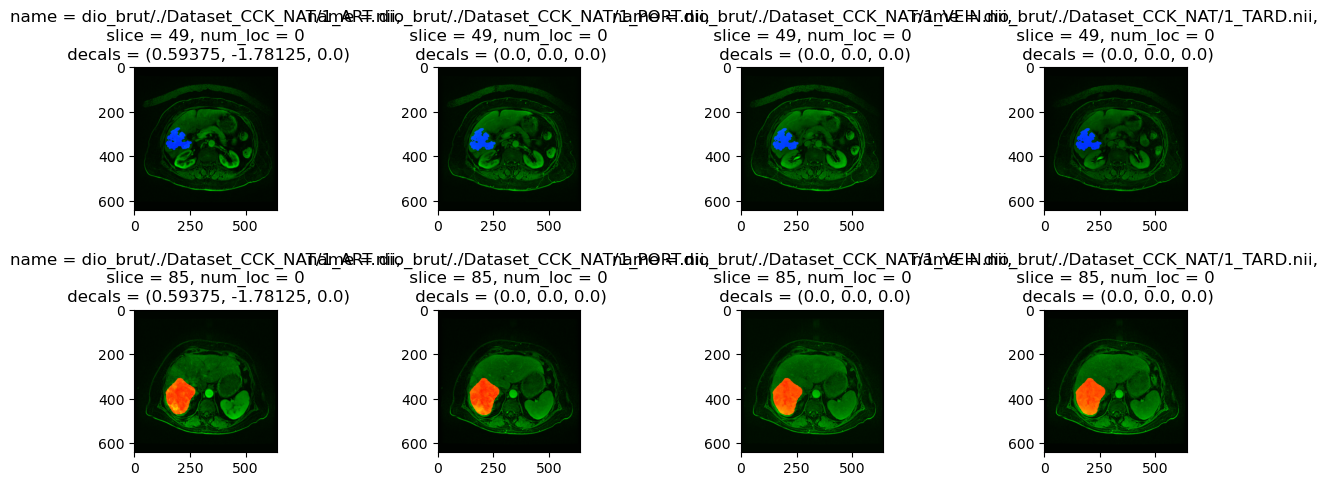

['../data/radio_brut/./Dataset_CCK_NAT/2_ART.nii', '../data/radio_brut/./Dataset_CCK_NAT/2_PORT.nii', '../data/radio_brut/./Dataset_CCK_NAT/2_VEIN.nii', '../data/radio_brut/./Dataset_CCK_NAT/2_TARD.nii']


KeyboardInterrupt: 

<Figure size 1500x500 with 0 Axes>

In [5]:
start = 0
time_ref = 3
#ouille 83
#Tardif super!!
## Continuer avec ref_num
for num_ls_full in range(start, len(ls_image_full_time)):
    names = ls_image_full_time[num_ls_full]
    print(names)
    fenetre_z = range(-10, 11)
    fenetre_x = range(-4, 5)
    fenetre_y = range(-4, 5)
    plt.figure(figsize=(15,5))
    li_slices_masks, li_slices_images, li_images, li_masks = equalize_slices(ls_image_full_time, dict_image_full_time,force_spacing=np.array([0.59375, 0.59375, 1.5]), num=num_ls_full, key=None, show=False, do_nothing=False)
    # li_decal = np.array(find_best_decal_all_times_short(li_slices_masks, fenetre_z, fenetre_x=None, fenetre_y=None, mode="area"))
    li_enum = list(range(len(li_slices_images)))
    if len(li_enum) == len(time_inj):
        li_enum[time_ref] = 0
        li_enum[0] = time_ref
        local_time_ref = time_ref
    else: 
        local_time_ref = 0
    li_best_shift_x, li_best_shift_y, li_decal = find_best_all_area(li_masks, fenetre_z, fenetre_x, fenetre_y, local_time_ref)
    li_best_shift_z = [li_masks[0].GetSpacing()[2]*decal for decal in li_decal]
    #print(li_best_shift_x)
    #good_slices = get_good_slices_from_li(li_slices_images[local_time_ref], li_slices_masks[local_time_ref])
    for i_enum in range(len(li_slices_images)):
        i = li_enum[i_enum]
        name = names[i]
        image = li_images[i]
        mask = li_masks[i]
        if i == local_time_ref:
            echec = True
            erosion = 5
            while echec:
                mask_tot_ref = pipeline_3D(image, mask, sigma = 1, quantile = 0.4, interieur = 8, exterieur = 45, erosion = erosion, show = False, slice = 110)
                mask_tot = sitk.Image(mask_tot_ref)
                good_slices = get_good_slices_from_li(li_slices_images[local_time_ref], [mask_tot_ref[:,:,z] for z in range(mask_tot_ref.GetSize()[2])])
                good_slices_tumor = get_good_slices_from_li(li_slices_images[local_time_ref], [mask[:,:,z] for z in range(mask.GetSize()[2])])
                if len(good_slices) > 0:
                    echec = False
                else:
                    erosion -= 1
                    print(f"Nouvelle erosion = {erosion}")
            slice_vue_tumor_ref = good_slices_tumor[len(good_slices_tumor)//2]
            slice_ref = good_slices[len(good_slices)//2]
            #print(slice_ref)
        else:
            mask_tot = translate_mask(mask_tot_ref, li_best_shift_x[i], li_best_shift_y[i], li_best_shift_z[i])
        slice_num = int(slice_ref + li_decal[i])
        slice_num_tumor = int(slice_vue_tumor_ref + li_decal[i])
        mask_superpose_simple(image[:,:,slice_num],mask[:,:,slice_num],other_mask =  mask_tot[:,:,slice_num], max_num = len(names), num = i+ 1, legend = f"name = {name[10:]},\n slice = {slice_num}, num_loc = {num_ls_full} \n decals = {( li_best_shift_x[i],  li_best_shift_y[i], li_best_shift_z[i])}", line = 2)
        mask_superpose_simple(image[:,:,slice_num_tumor],mask[:,:,slice_num_tumor],other_mask =  mask_tot[:,:,slice_num_tumor], max_num = len(names), num = len(names) + i+ 1, legend = f"name = {name[10:]},\n slice = {slice_num_tumor}, num_loc = {num_ls_full} \n decals = {( li_best_shift_x[i],  li_best_shift_y[i], li_best_shift_z[i])}", line = 2)
    plt.subplots_adjust(hspace=0.7) 
    plt.show()
    

t = 0
[0.0, 0.0, -1.78125, 1.1875]                
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, -1.1875, -1.1875, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 1.1875, 2.375, 1.1875]
[0.0, -1.78125, -1.78125, -1.78125]
[0.0, 0.0, 0.0, 2.375]
[0.0, 0.0, 0.0, 0.0]
[0.0, 2.375, 2.375, 1.1875]
[0.0, -2.375, -1.78125, -1.78125]
[0.0, 0.0, 0.0, 0.0]
[0.0, -2.375, -2.375, -2.375]
[0.0, -1.1875, 0.0]
[0.0, -2.375]
[0.0, 0.0, 0.0, 0.0]

t = 3
[-1.1875, -0.59375, -2.375, 0.0]    
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, -1.1875, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[-1.1875, 0.0, 1.1875, 0.0]
[1.78125, 0.0, 0.0, 0.0]
[-2.375, -2.375, -2.375, 0.0]
[0.0, 0.0, 0.0, 0.0]
[-1.1875, 2.375, 2.375, 0.0]
[1.78125, -1.78125, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[2.375, 0.0, 0.0, 0.0]
[0.0, -1.1875, 0.0]
[0.0, -2.375]
[0.0, 0.0, 0.0, 0.0]
[-1.1875, 0.0, 0.0, 0.0]
[-2.375, -2.375, 0.0, 0.0]
[-1.1875, 1.1875, 1.1875, 0.0]

 t = 1

 [0.0, 0.0, -1.78125, 0.59375]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[1.1875, 0.0, 1.1875, 1.1875]
[0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0]
[-1.1875, 0.0, 1.1875, 0.0]
[1.78125, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 2.375]
[0.0, 0.0, 0.0, 0.0]
[-2.375, 0.0, 0.0, -2.375]
[2.375, 0.0, 1.78125, 1.78125]
[0.0, 0.0, 0.0, 0.0]
[2.375, 0.0, 0.0, 0.0]
[0.0, -1.1875, 0.0]
[0.0, -2.375]
[0.0, 0.0, 0.0, 0.0]
[-1.1875, 0.0, 0.0, 0.0]
[0.0, 0.0, 2.375, 2.375]
[-1.1875, 0.0, 0.0, -1.1875]

